# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [28]:
import numpy as np
import os
from skimage.transform import resize
from skimage.io import imread
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [29]:
np.random.seed(100)
import random as rn
rn.seed(100)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(100)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [30]:
ls

 Volume in drive C is Windows
 Volume Serial Number is FE9E-774F

 Directory of C:\Users\PRATIK\OneDrive\Desktop\UpGrad\Neural Networks\Gesture Recognition

03-02-2024  17:10    <DIR>          .
03-02-2024  11:32    <DIR>          ..
03-02-2024  12:02    <DIR>          .ipynb_checkpoints
03-02-2024  15:08    <DIR>          model_init_2024-02-0312_39_30.075273
03-02-2024  15:12    <DIR>          model_init_2024-02-0315_11_35.594310
03-02-2024  15:31    <DIR>          model_init_2024-02-0315_30_58.960918
03-02-2024  15:57    <DIR>          model_init_2024-02-0315_56_08.312308
03-02-2024  17:01    <DIR>          model_init_2024-02-0315_59_03.842463
03-02-2024  17:10           238,361 Neural_Nets_Project_Starter_Code.ipynb
03-02-2024  11:54    <DIR>          Project_data
               1 File(s)        238,361 bytes
               9 Dir(s)  103,574,802,432 bytes free


In [31]:
train_doc = np.random.permutation(open('C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [36]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/train'
val_path = 'C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Base Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [32]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK\AppData\Local\Temp\ipykernel_20320\3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.8405 - categorical_accuracy: 0.3527Source path =  C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2024-02-0312_39_30.075273\model-00001-1.84053-0.35268-1.79883-0.24219.h5
21/21 [==============================] - 173s 8s/step - loss: 1.8405 - categorical_accuracy: 0.3527 - val_loss: 1.7988 - val_categorical_accuracy: 0.2422 - lr: 0.0100
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.2743 - categorical_accuracy: 0.5432
Epoch 2: saving model to model_init_2024-02-0312_39_30.075273\model-00002-1.27428-0.54315-1.71243-0.19531.h5
21/21 [==============================] - 173s 8s/step - loss: 1.2743 - categorical_accuracy: 0.5432 - val_loss: 1.7124 - val_categorical_accuracy: 0.

In [13]:
print("Total Params:", model.count_params())

Total Params: 1733509


<Figure size 1000x1000 with 0 Axes>

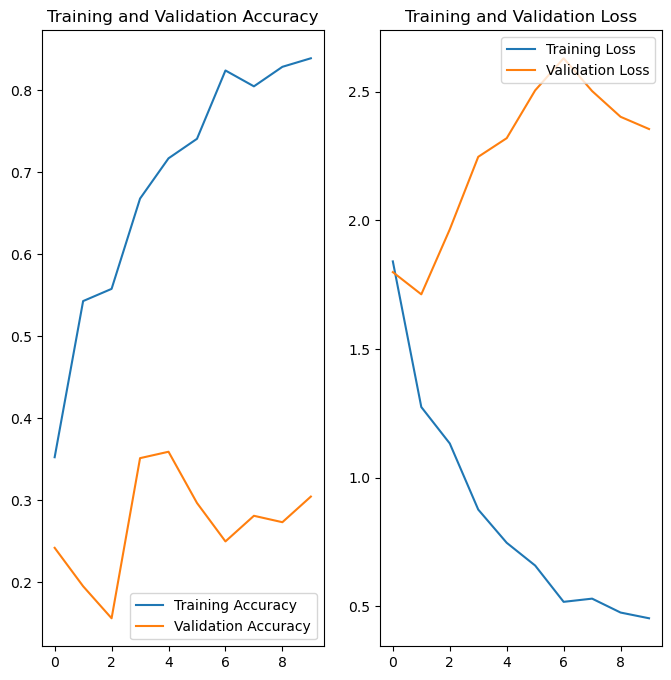

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 2: 
Training accuracy and loss looks good but the validation metrics are going haywire.
Trying to double both the batch size and the number of epochs to see if an intensive training works for the model better.

In [15]:
new_batch_size = 64
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

In [16]:
num_epochs2=20
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_20320\2304494718.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1,


Source path =  C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/train ; batch size = 64
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.4360 - categorical_accuracy: 0.8594 Source path =  C:/Users/PRATIK/OneDrive/Desktop/UpGrad/Neural Networks/Gesture Recognition/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2024-02-0312_39_30.075273\model-00001-0.43597-0.85938-2.63205-0.18750.h5
21/21 [==============================] - 336s 16s/step - loss: 0.4360 - categorical_accuracy: 0.8594 - val_loss: 2.6321 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.3358 - categorical_accuracy: 0.8966 
Epoch 2: saving model to model_init_2024-02-0312_39_30.075273\model-00002-0.33580-0.89658-2.33053-0.26953.h5
21/21 [==============================] - 352s 17s/step - loss: 0.3358 - categorical_accuracy: 0.8966 - val_loss: 2.3305 - val_categorical_accuracy

<Figure size 1000x1000 with 0 Axes>

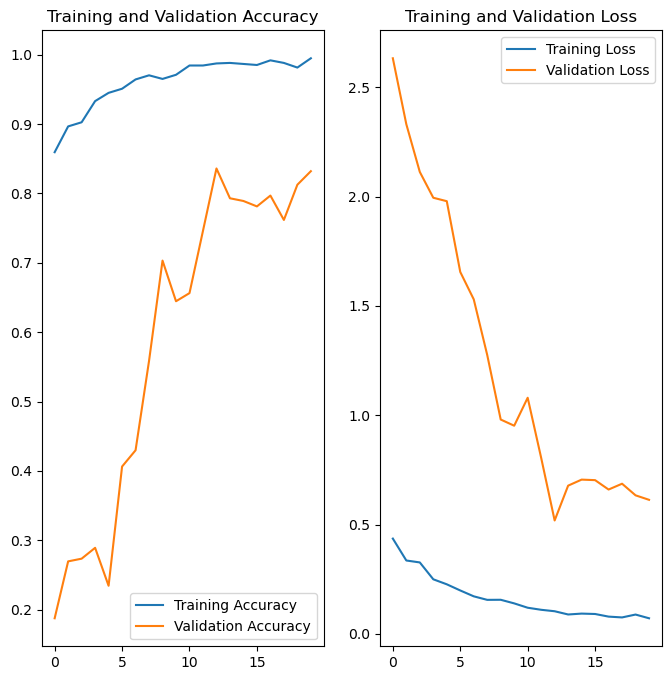

In [17]:
plt.figure(figsize = (10,10))

acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 3:
There seems to be a significant improvement in the validation accuracy and loss. However training it for more epochs would cause the model to overfit and increasing the batchsize would result in a memory error.

To tackle this, the next experiment is to increase the image size and by taking a higher number of images from each frame

In [15]:
def new_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(120,120)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,20,120,120,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(120,120)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    


In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data\\train'
val_path = 'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(20,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [17]:
new_batch_size = 64
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

In [18]:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 64)    0

In [19]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [10]:
num_epochs3=20
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs3, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_16724\2878578356.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs3, verbose=1,


Source path =  Project_data\train ; batch size = 64
Epoch 1/20
 3/11 [=======>......................] - ETA: 36:49 - loss: 2.0181 - categorical_accuracy: 0.2656

KeyboardInterrupt: 

# Model 4
20 Epochs and 64 batch size causes the kernel to crash every time. Lowering the number of epochs and batch size, only taking in more images from a folder than Model 2 did.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data\\train'
val_path = 'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [21]:
new_batch_size = 32
train_generator = new_generator(train_path, train_doc, new_batch_size)
val_generator = new_generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

In [22]:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 64)    0

In [23]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [24]:
num_epochs4=10
history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs4, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_15764\3088645474.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs4, verbose=1,


Source path =  Project_data\train ; batch size = 32
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6641 - categorical_accuracy: 0.4226 Source path =  Project_data\val ; batch size = 32

Epoch 1: saving model to model_init_2024-02-0315_59_03.842463\model-00001-1.66412-0.42262-1.53328-0.28125.h5
21/21 [==============================] - 657s 30s/step - loss: 1.6641 - categorical_accuracy: 0.4226 - val_loss: 1.5333 - val_categorical_accuracy: 0.2812 - lr: 0.0100
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.1562 - categorical_accuracy: 0.5818 
Epoch 2: saving model to model_init_2024-02-0315_59_03.842463\model-00002-1.15617-0.58185-1.74724-0.28125.h5
21/21 [==============================] - 601s 29s/step - loss: 1.1562 - categorical_accuracy: 0.5818 - val_loss: 1.7472 - val_categorical_accuracy: 0.2812 - lr: 0.0100
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.8054 - categorical_accuracy: 0.6964 
Epoch 3: saving model t

KeyboardInterrupt: 

- As we can see, the validation accuracy is not improving at all and is in the low 0.1 - 0.2 range, while the training accuracy has gone up considerably uptil the 80s.
- This is a clear early indication of the model's overfitting behaviour and hence there is no point in training the model for the rest of the epochs

# Model 5:
We will now try to alter the basic structure of the base model and check if any other architecture suits better for this machine learing problem.

We hence use the CNN+LSTM model 

In [34]:
from keras.layers import LSTM

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [37]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_6 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_10 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_7 (Activation)   (None, 6, 40, 40, 64)    

In [38]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [39]:
num_epochs5=20
history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_15764\3124486736.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs5, verbose=1,


Source path =  Project_data\train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.0051 - categorical_accuracy: 0.2723Source path =  Project_data\val ; batch size = 32

Epoch 1: saving model to model_init_2024-02-0315_59_03.842463\model-00001-2.00505-0.27232-1.59140-0.23438.h5
21/21 [==============================] - 167s 8s/step - loss: 2.0051 - categorical_accuracy: 0.2723 - val_loss: 1.5914 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.8005 - categorical_accuracy: 0.3110
Epoch 2: saving model to model_init_2024-02-0315_59_03.842463\model-00002-1.80050-0.31101-1.57907-0.25781.h5
21/21 [==============================] - 164s 8s/step - loss: 1.8005 - categorical_accuracy: 0.3110 - val_loss: 1.5791 - val_categorical_accuracy: 0.2578 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.6390 - categorical_accuracy: 0.3586
Epoch 3: saving model to mod

<Figure size 1000x1000 with 0 Axes>

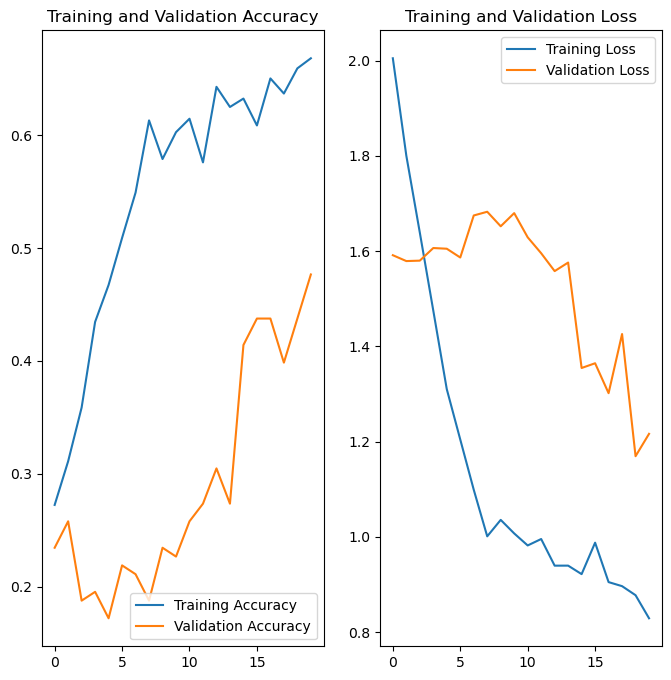

In [41]:
plt.figure(figsize = (10,10))

acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 6:
Even though the accuracy and loss is considerably low, it can be seen that it is improving steadily
In this case, beforing concluding anything about the model, it is a better option to let the model train for a bit longer.
Increasing the batch size and number of epochs to see the effect on the metrics

In [42]:
from keras.layers import LSTM

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [43]:
batch_size = 64
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_9 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_14 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_10 (Activation)  (None, 6, 40, 40, 64)    

In [44]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [45]:
num_epochs6=40
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs6, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_15764\2451560862.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs6, verbose=1,


Source path =  Project_data\train ; batch size = 64
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.9473 - categorical_accuracy: 0.3080 Source path =  Project_data\val ; batch size = 64

Epoch 1: saving model to model_init_2024-02-0315_59_03.842463\model-00001-1.94728-0.30804-1.59193-0.22656.h5
21/21 [==============================] - 318s 15s/step - loss: 1.9473 - categorical_accuracy: 0.3080 - val_loss: 1.5919 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.4479 - categorical_accuracy: 0.4487 
Epoch 2: saving model to model_init_2024-02-0315_59_03.842463\model-00002-1.44787-0.44866-1.61029-0.17188.h5
21/21 [==============================] - 335s 16s/step - loss: 1.4479 - categorical_accuracy: 0.4487 - val_loss: 1.6103 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 1.2111 - categorical_accuracy: 0.5290 
Epoch 3: saving model t

Epoch 22/40
21/21 [==============================] - ETA: 0s - loss: 0.1877 - categorical_accuracy: 0.9576 
Epoch 22: saving model to model_init_2024-02-0315_59_03.842463\model-00022-0.18766-0.95759-0.73743-0.76953.h5
21/21 [==============================] - 342s 16s/step - loss: 0.1877 - categorical_accuracy: 0.9576 - val_loss: 0.7374 - val_categorical_accuracy: 0.7695 - lr: 0.0020
Epoch 23/40
21/21 [==============================] - ETA: 0s - loss: 0.1774 - categorical_accuracy: 0.9591 
Epoch 23: saving model to model_init_2024-02-0315_59_03.842463\model-00023-0.17738-0.95908-0.73201-0.78125.h5
21/21 [==============================] - 344s 17s/step - loss: 0.1774 - categorical_accuracy: 0.9591 - val_loss: 0.7320 - val_categorical_accuracy: 0.7812 - lr: 0.0020
Epoch 24/40
21/21 [==============================] - ETA: 0s - loss: 0.1823 - categorical_accuracy: 0.9524 
Epoch 24: saving model to model_init_2024-02-0315_59_03.842463\model-00024-0.18225-0.95238-0.77098-0.79688.h5
21/21 [===

<Figure size 1000x1000 with 0 Axes>

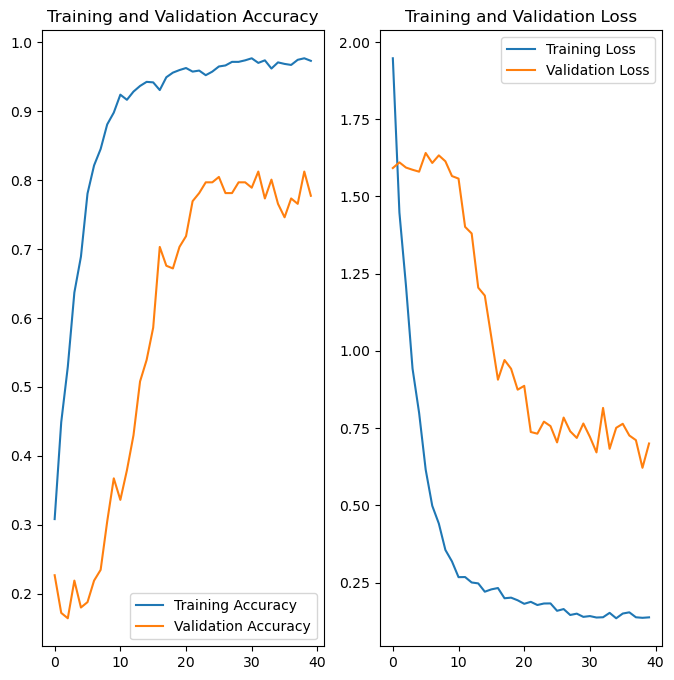

In [46]:
plt.figure(figsize = (10,10))

acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(num_epochs6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 7

In [47]:
from keras.layers import LSTM

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [48]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_12 (Activation)  (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_18 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 6, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_13 (Activation)  (None, 6, 40, 40, 64)    

In [49]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [50]:
num_epochs7=30
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs7, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_15764\3807332914.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs7, verbose=1,


Source path =  Project_data\train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.0054 - categorical_accuracy: 0.2604Source path =  Project_data\val ; batch size = 32

Epoch 1: saving model to model_init_2024-02-0315_59_03.842463\model-00001-2.00538-0.26042-1.60486-0.20312.h5
21/21 [==============================] - 174s 8s/step - loss: 2.0054 - categorical_accuracy: 0.2604 - val_loss: 1.6049 - val_categorical_accuracy: 0.2031 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6704 - categorical_accuracy: 0.3571
Epoch 2: saving model to model_init_2024-02-0315_59_03.842463\model-00002-1.67042-0.35714-1.57882-0.17969.h5
21/21 [==============================] - 167s 8s/step - loss: 1.6704 - categorical_accuracy: 0.3571 - val_loss: 1.5788 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4952 - categorical_accuracy: 0.4196
Epoch 3: saving model to mod

Epoch 22/30
21/21 [==============================] - ETA: 0s - loss: 0.4822 - categorical_accuracy: 0.8423
Epoch 22: saving model to model_init_2024-02-0315_59_03.842463\model-00022-0.48219-0.84226-0.89703-0.64844.h5
21/21 [==============================] - 166s 8s/step - loss: 0.4822 - categorical_accuracy: 0.8423 - val_loss: 0.8970 - val_categorical_accuracy: 0.6484 - lr: 4.0000e-04
Epoch 23/30
21/21 [==============================] - ETA: 0s - loss: 0.5248 - categorical_accuracy: 0.8036
Epoch 23: saving model to model_init_2024-02-0315_59_03.842463\model-00023-0.52483-0.80357-0.89654-0.64062.h5
21/21 [==============================] - 168s 8s/step - loss: 0.5248 - categorical_accuracy: 0.8036 - val_loss: 0.8965 - val_categorical_accuracy: 0.6406 - lr: 4.0000e-04
Epoch 24/30
21/21 [==============================] - ETA: 0s - loss: 0.4926 - categorical_accuracy: 0.8363
Epoch 24: saving model to model_init_2024-02-0315_59_03.842463\model-00024-0.49261-0.83631-0.85918-0.64844.h5
21/21 [

In [51]:
num_epochs7=40
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs7, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


C:\Users\PRATIK\AppData\Local\Temp\ipykernel_15764\2867605518.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs7, verbose=1,


Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 0.4626 - categorical_accuracy: 0.8542
Epoch 1: saving model to model_init_2024-02-0315_59_03.842463\model-00001-0.46255-0.85417-0.70619-0.71094.h5
21/21 [==============================] - 169s 8s/step - loss: 0.4626 - categorical_accuracy: 0.8542 - val_loss: 0.7062 - val_categorical_accuracy: 0.7109 - lr: 4.0000e-04
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 0.4593 - categorical_accuracy: 0.8467
Epoch 2: saving model to model_init_2024-02-0315_59_03.842463\model-00002-0.45928-0.84673-0.71124-0.71875.h5
21/21 [==============================] - 167s 8s/step - loss: 0.4593 - categorical_accuracy: 0.8467 - val_loss: 0.7112 - val_categorical_accuracy: 0.7188 - lr: 4.0000e-04
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 0.4713 - categorical_accuracy: 0.8289
Epoch 3: saving model to model_init_2024-02-0315_59_03.842463\model-00003-0.47133-0.82887-0.75669-0.71094.h5
21/21 [======

Epoch 22/40
21/21 [==============================] - ETA: 0s - loss: 0.3799 - categorical_accuracy: 0.8765
Epoch 22: saving model to model_init_2024-02-0315_59_03.842463\model-00022-0.37991-0.87649-0.65327-0.77344.h5
21/21 [==============================] - 180s 9s/step - loss: 0.3799 - categorical_accuracy: 0.8765 - val_loss: 0.6533 - val_categorical_accuracy: 0.7734 - lr: 1.6000e-05
Epoch 23/40
21/21 [==============================] - ETA: 0s - loss: 0.4171 - categorical_accuracy: 0.8571
Epoch 23: saving model to model_init_2024-02-0315_59_03.842463\model-00023-0.41711-0.85714-0.66742-0.75781.h5
21/21 [==============================] - 171s 8s/step - loss: 0.4171 - categorical_accuracy: 0.8571 - val_loss: 0.6674 - val_categorical_accuracy: 0.7578 - lr: 1.6000e-05
Epoch 24/40
21/21 [==============================] - ETA: 0s - loss: 0.4361 - categorical_accuracy: 0.8467
Epoch 24: saving model to model_init_2024-02-0315_59_03.842463\model-00024-0.43613-0.84673-0.68845-0.71094.h5
21/21 [

<Figure size 1000x1000 with 0 Axes>

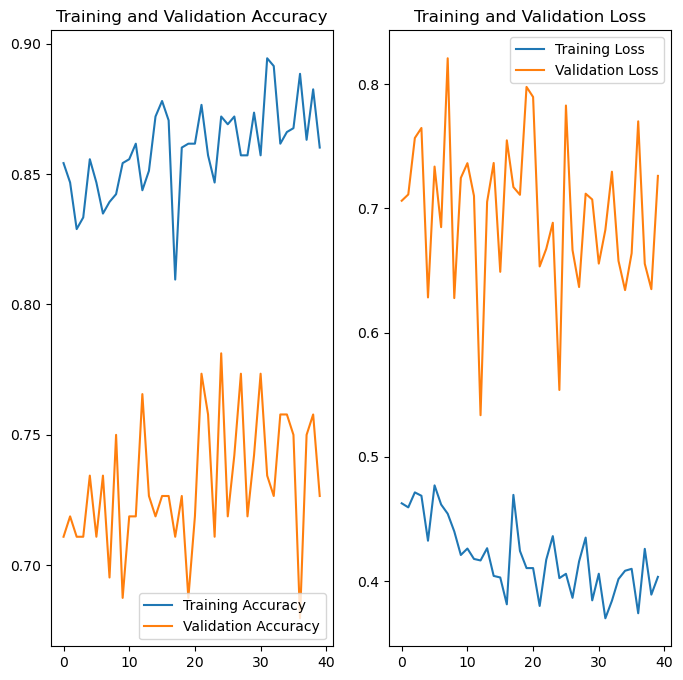

In [52]:
plt.figure(figsize = (10,10))

acc = history7.history['categorical_accuracy']
val_acc = history7.history['val_categorical_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(num_epochs6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion:
The simplest model was the best working model so far.  Going ahead with the Model 2